# ENV/ATM 415: Climate Laboratory

[Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany

# Lecture 8: Radiative Equilibrium

____________
<a id='section1'></a>

## 1. The observed annual, global mean temperature profile
____________

We want to model the OLR in a column whose temperatures match observations. As we've done before, we'll calculate the global, annual mean air temperature from the NCEP Reanalysis data.

This just repeats what we did in the notebook `L06_Radiation.ipynb`.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from xarray.ufuncs import cos, deg2rad, log
import climlab
from metpy.plots import SkewT

In [2]:
# This will try to read the data over the internet.
temperature_filename = 'air.mon.1981-2010.ltm.nc'  # temperature
humidity_filename = 'shum.mon.1981-2010.ltm.nc'    # specific humidity
#  to read over internet
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/"
path = ncep_url
#  Open handle to data
ncep_air = xr.open_dataset(path + temperature_filename, decode_times=False)
ncep_shum = xr.open_dataset(path + humidity_filename, decode_times=False)

In [3]:
#  Take global, annual average and convert to Kelvin
weight = cos(deg2rad(ncep_air.lat)) / cos(deg2rad(ncep_air.lat)).mean(dim='lat')
Tglobal = (ncep_air.air * weight).mean(dim=('lat','lon','time'))
print( Tglobal)

<xarray.DataArray (level: 17)>
array([ 15.179082,  11.207002,   7.838327,   0.219941,  -6.448343, -14.888844,
       -25.570467, -39.369685, -46.797908, -53.652235, -60.563551, -67.006048,
       -65.532927, -61.486637, -55.853581, -51.593945, -43.219982])
Coordinates:
  * level    (level) float32 1000.0 925.0 850.0 700.0 600.0 500.0 400.0 ...


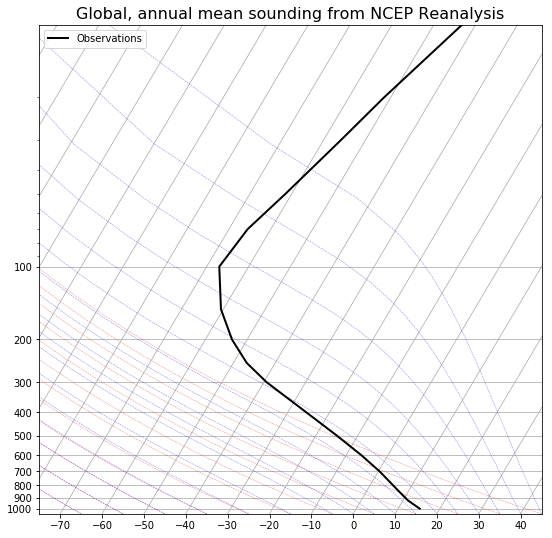

In [4]:
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)
skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')
skew.ax.set_ylim(1050, 10)
skew.ax.set_xlim(-75, 45)
# Add the relevant special lines
skew.plot_dry_adiabats(linewidth=0.5)
skew.plot_moist_adiabats(linewidth=0.5)
#skew.plot_mixing_lines()
skew.ax.legend()
skew.ax.set_title('Global, annual mean sounding from NCEP Reanalysis', 
             fontsize = 16);

We are now going to work on some single-column models of the vertical temperature profile to understand physical factors determining the observed profile.

____________
<a id='section2'></a>

## 2. Radiative equilibrium -- the concept
____________

Models of radiative transfer slice up the atmospheric air column into a series of layer, and calculate the **emission** and **absorption** of radiation within each layer.

We can think of following a beam of longwave radiation up from the surface through each layer, as sketched here.:

![Sketch of layer model](http://www.atmos.albany.edu/facstaff/brose/classes/ENV415_Spring2018/images/2layerAtm_sketch.png)

The concept of **radiative equilibrium** means that we **ignore all methods of heat exchange except for radiation**, and ask what temperature profile would exist under that assumption?

We can answer that question by using a radiative transfer model to explicity compute the shortwave and longwave beams, and the warming/cooling of each layer associated with the radiative sources and sinks of energy.

Basically, we reach radiative equilibrium when **energy is received and lost through radiation at the same rate in every layer**.

Because of the complicated dependence of emission/absorption features on the wavelength of radiation and the different gases, the beam is divided up into many different pieces representing different parts of the electromagnetic spectrum.

We will not look explicitly at this complexity here, but we will **use a model** that represents these processes at the same level of detail we would in a GCM.

____________
<a id='section3'></a>

## 3. Pure radiative equilibrium in the RRTMG model
____________

We're going to use a model called the [Rapid Radiative Transfer Model](http://rtweb.aer.com/rrtm_frame.html) or RRTMG. This is a "serious" and widely-used radiation model, used in many comprehensive GCMs and Numerical Weather Prediction models.

`climlab` provides an easy-to-use Python wrapper for the RRTMG code.

Before setting up the model, we need some water vapor data.

We're actually going to use the specific humidity field from our CESM control simulation:

In [5]:
datapath = "http://ramadda.atmos.albany.edu:8080/repository/opendap/latest/Top/Users/BrianRose/CESM_runs/"
endstr = "/entry.das"
atm_control = xr.open_dataset( datapath + 'som_1850_f19/som_1850_f19.cam.h0.clim.nc' + endstr, decode_times=False)

Take global, annual average of the specific humidity:

In [6]:
Qglobal = ((atm_control.Q * atm_control.gw)/atm_control.gw.mean(dim='lat')).mean(dim=('lat','lon','time'))
Qglobal

<xarray.DataArray (lev: 26)>
array([  2.162550e-06,   2.159117e-06,   2.149430e-06,   2.133799e-06,
         2.119934e-06,   2.111498e-06,   2.095464e-06,   2.118271e-06,
         2.441435e-06,   3.155951e-06,   5.057482e-06,   9.663076e-06,
         2.100241e-05,   4.803590e-05,   1.056113e-04,   2.117998e-04,
         3.935585e-04,   7.106597e-04,   1.340892e-03,   2.050905e-03,
         3.162419e-03,   4.961048e-03,   6.608193e-03,   8.364253e-03,
         9.364700e-03,   9.629375e-03])
Coordinates:
  * lev      (lev) float64 3.545 7.389 13.97 23.94 37.23 53.11 70.06 85.44 ...

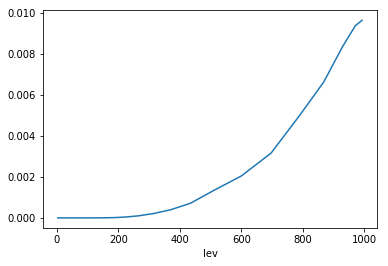

In [7]:
Qglobal.plot()

### Create a single-column model on the same grid as this water vapor data:

In [8]:
#  Make a model on same vertical domain as the GCM
state = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
state

{'Tatm': Field([ 200.  ,  203.12,  206.24,  209.36,  212.48,  215.6 ,  218.72,
         221.84,  224.96,  228.08,  231.2 ,  234.32,  237.44,  240.56,
         243.68,  246.8 ,  249.92,  253.04,  256.16,  259.28,  262.4 ,
         265.52,  268.64,  271.76,  274.88,  278.  ]), 'Ts': Field([ 288.])}

In [9]:
radmodel_noH2O = climlab.radiation.RRTMG(name='Radiation (no H2O)',
                              state=state, 
                              specific_humidity=np.zeros_like(state.Tatm),
                              albedo = 0.25,
                              timestep = climlab.constants.seconds_per_day,
                             )
print(radmodel_noH2O)

Getting ozone data from /Users/br546577/anaconda3/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
climlab Process of type <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (26,) 
The subprocess tree: 
Radiation (no H2O): <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
   SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
   LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>



In [10]:
radmodel_noH2O.absorber_vmr

{'CCL4': 0.0,
 'CFC11': 0.0,
 'CFC12': 0.0,
 'CFC22': 0.0,
 'CH4': 1.65e-06,
 'CO2': 0.000348,
 'N2O': 3.06e-07,
 'O2': 0.21,
 'O3': array([  7.52507018e-06,   8.51545793e-06,   7.87041289e-06,
          5.59601020e-06,   3.46128454e-06,   2.02820936e-06,
          1.13263102e-06,   7.30182697e-07,   5.27326553e-07,
          3.83940962e-07,   2.82227214e-07,   2.12188506e-07,
          1.62569291e-07,   1.17991442e-07,   8.23582543e-08,
          6.25738219e-08,   5.34457156e-08,   4.72688637e-08,
          4.23614749e-08,   3.91392482e-08,   3.56025264e-08,
          3.12026770e-08,   2.73165152e-08,   2.47190016e-08,
          2.30518624e-08,   2.22005071e-08])}

In [11]:
radmodel_noH2O.specific_humidity

Field([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [12]:
radmodel_noH2O.Ts

Field([ 288.])

In [13]:
radmodel_noH2O.Tatm

Field([ 200.  ,  203.12,  206.24,  209.36,  212.48,  215.6 ,  218.72,
        221.84,  224.96,  228.08,  231.2 ,  234.32,  237.44,  240.56,
        243.68,  246.8 ,  249.92,  253.04,  256.16,  259.28,  262.4 ,
        265.52,  268.64,  271.76,  274.88,  278.  ])

In [14]:
radmodel_noH2O.step_forward()

In [15]:
radmodel_noH2O.Ts

Field([ 287.27803925])

In [16]:
radmodel_noH2O.diagnostics

{'ASR': Field([ 237.67817151]),
 'ASRcld': Field([ 0.]),
 'ASRclr': Field([ 237.67817151]),
 'LW_flux_down': Field([  0.        ,   1.0363337 ,   1.81546673,   3.124346  ,
          4.85329859,   6.83592517,   8.88064984,  10.75502083,
         12.4742788 ,  14.32390099,  16.3980802 ,  18.70691148,
         21.28451455,  24.17165307,  27.4207579 ,  31.0851478 ,
         35.23672196,  39.97120168,  45.41486753,  51.68291262,
         58.63834343,  65.71358329,  72.40889738,  78.39650114,
         83.33683302,  87.05042865,  92.15957478]),
 'LW_flux_down_clr': Field([  0.        ,   1.0363337 ,   1.81546673,   3.124346  ,
          4.85329859,   6.83592517,   8.88064984,  10.75502083,
         12.4742788 ,  14.32390099,  16.3980802 ,  18.70691148,
         21.28451455,  24.17165307,  27.4207579 ,  31.0851478 ,
         35.23672196,  39.97120168,  45.41486753,  51.68291262,
         58.63834343,  65.71358329,  72.40889738,  78.39650114,
         83.33683302,  87.05042865,  92.15957478]),


In [17]:
radmodel_noH2O.ASR - radmodel_noH2O.OLR

Field([-91.23992244])

In [18]:
radmodel_noH2O.integrate_years(1)

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 1.0020747876340685 years.


In [19]:
radmodel_noH2O.ASR - radmodel_noH2O.OLR

Field([-1.76557602])

In [20]:
while np.abs(radmodel_noH2O.ASR - radmodel_noH2O.OLR > 0.01):
    radmodel_noH2O.step_forward()

In [21]:
def add_profile(skew, model, label):
    line = skew.plot(model.lev, model.Tatm - climlab.constants.tempCtoK,
             label=label, linewidth=2)[0]
    skew.plot(1000, model.Ts - climlab.constants.tempCtoK, 'o', 
              markersize=8, color=line.get_color())
    skew.ax.legend()
    return fig

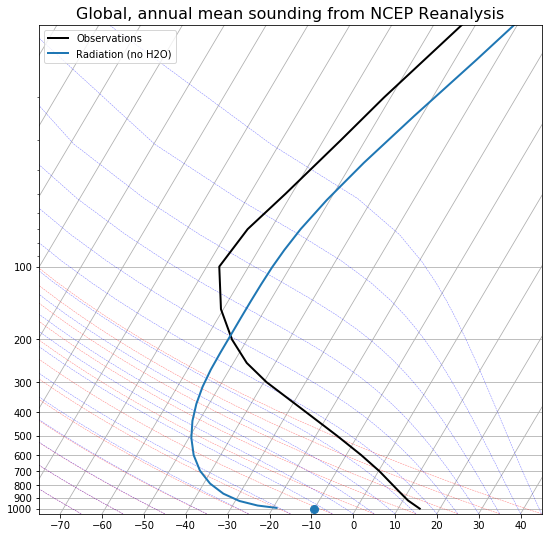

In [22]:
add_profile(skew, radmodel_noH2O, radmodel_noH2O.name)